In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pmdarima import auto_arima

# Project_Data1.xlsx 전처리

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = pd.read_excel('C:/Users/campus4D045/Desktop/기계학습/Project_Data1.xlsx')
df.describe()

,일자,현재발전출력,수평일사량1,수평일사량2,경사일사량1,경사일사량2,외기온도1,외기온도2
count,10950,10950.000000,10950.000000,10950.000000,10950.000000,10950.000000,10950.000000,10950.000000
mean,2018-12-31 18:42:24.657534464,1524.820355,230.222646,179.333677,268.453154,206.059806,10.926778,10.705167
min,2016-01-01 00:00:00,0.000000,0.003874,0.001222,0.026364,0.000000,-11.483838,-11.483838
25%,2017-07-02 00:00:00,48.239667,92.511838,66.228846,124.028144,66.511936,4.566542,3.632296
50%,2018-12-31 12:00:00,271.103925,210.744395,150.383368,250.280604,176.532612,9.972232,7.682633
75%,2020-07-02 00:00:00,766.153642,344.877557,279.373709,398.176523,328.630104,16.236982,13.582874
max,2021-12-31 00:00:00,15198.240234,657.568471,625.428754,712.759448,716.524755,33.379454,253.434425
std,NaN,3061.868376,160.167291,133.628585,171.394361,157.573487,7.618199,18.351585


In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   위치      10950 non-null  object        
 1   일자      10950 non-null  datetime64[ns]
 2   현재발전출력  10950 non-null  float64       
 3   수평일사량1  10950 non-null  float64       
 4   수평일사량2  10950 non-null  float64       
 5   경사일사량1  10950 non-null  float64       
 6   경사일사량2  10950 non-null  float64       
 7   외기온도1   10950 non-null  float64       
 8   외기온도2   10950 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 770.1+ KB


In [160]:
# 위치 컬럼 값 대체
df['위치'] = df['위치'].replace({'A': '당진', 'C': '울산', 'D': '영광', 'E': '동해'})

In [161]:
df.head()

,위치,일자,현재발전출력,수평일사량1,수평일사량2,경사일사량1,경사일사량2,외기온도1,외기온도2
0,당진,2019-01-01,110.657369,126.177314,154.397648,132.259603,160.382978,14.841146,15.428378
1,당진,2019-01-02,328.857233,352.846093,372.683510,382.959001,406.382636,15.685417,14.837355
2,당진,2019-01-03,344.740215,388.097375,424.301904,421.362986,459.246443,15.189286,16.407851
3,당진,2019-01-04,359.595589,358.813102,383.930114,380.419512,407.340175,15.935537,16.102201
4,당진,2019-01-05,358.737685,319.165867,355.007110,338.567568,379.146572,16.579135,16.859500


In [162]:
# 월을 기준으로 계절을 설정하는 함수 정의
def get_season(month):
    if month in [12, 1, 2]:
        return '겨울'
    elif month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    else:
        return '가을'

# 계절 컬럼 추가
df['계절'] = df['일자'].dt.month.apply(get_season)

In [164]:
# '위치' 컬럼에 'B'가 포함된 행 제거
df = df[~df['위치'].str.contains('B')]

df['위치'].unique()

array(['당진', '울산', '영광', '동해'], dtype=object)

In [165]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/기계학습/weather.csv'
df.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/기계학습/weather.csv 경로에 저장되었습니다.


In [166]:
df2 = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather.csv')
df2.head()

,위치,일자,현재발전출력,수평일사량1,수평일사량2,경사일사량1,경사일사량2,외기온도1,외기온도2,계절
0,당진,2019-01-01,110.657369,126.177314,154.397648,132.259603,160.382978,14.841146,15.428378,겨울
1,당진,2019-01-02,328.857233,352.846093,372.683510,382.959001,406.382636,15.685417,14.837355,겨울
2,당진,2019-01-03,344.740215,388.097375,424.301904,421.362986,459.246443,15.189286,16.407851,겨울
3,당진,2019-01-04,359.595589,358.813102,383.930114,380.419512,407.340175,15.935537,16.102201,겨울
4,당진,2019-01-05,358.737685,319.165867,355.007110,338.567568,379.146572,16.579135,16.859500,겨울


In [167]:
df2['위치'].unique()

array(['당진', '울산', '영광', '동해'], dtype=object)

# 현재발전출력

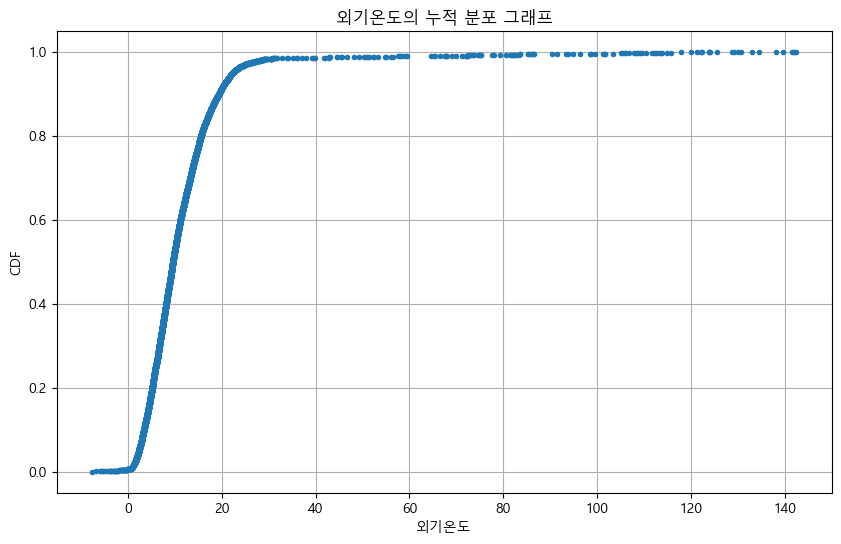

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '평균기온' 열을 선택하고 결측치 처리
temperature = df['외기온도'].dropna()

# 데이터 정렬
temperature_sorted = np.sort(temperature)

# CDF 계산
cdf = np.arange(1, len(temperature_sorted) + 1) / len(temperature_sorted)

# 누적 분포 그래프 작성
plt.figure(figsize=(10, 6))
plt.plot(temperature_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('외기온도')
plt.ylabel('CDF')
plt.title('외기온도의 누적 분포 그래프')
plt.grid(True)
plt.show()

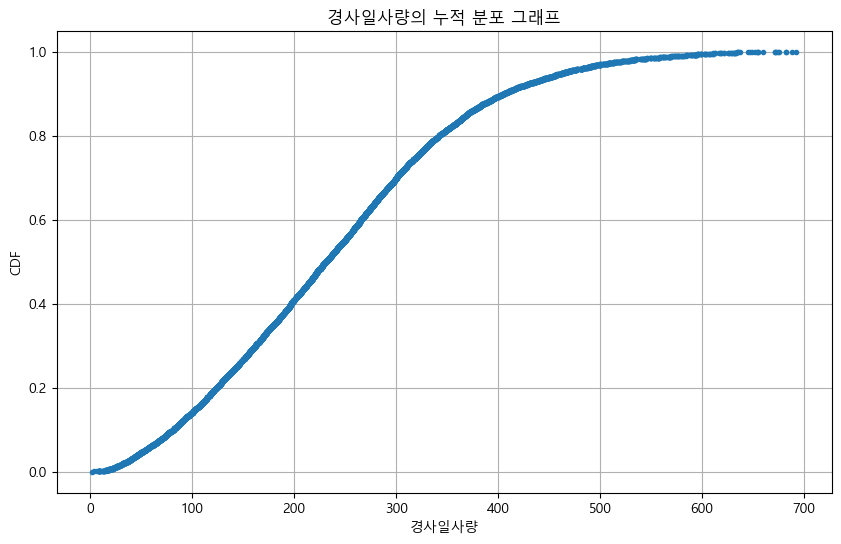

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '강수 계속시간(hr)' 열을 선택하고 결측치 처리
temperature = df['경사일사량'].dropna()

# 데이터 정렬
temperature_sorted = np.sort(temperature)

# CDF 계산
cdf = np.arange(1, len(temperature_sorted) + 1) / len(temperature_sorted)

# 누적 분포 그래프 작성
plt.figure(figsize=(10, 6))
plt.plot(temperature_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('경사일사량')
plt.ylabel('CDF')
plt.title('경사일사량의 누적 분포 그래프')
plt.grid(True)
plt.show()

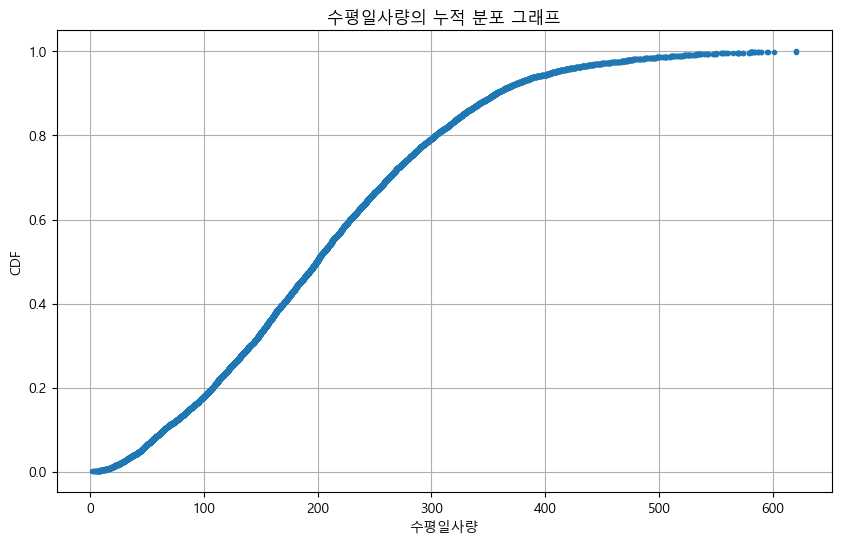

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '강수 계속시간(hr)' 열을 선택하고 결측치 처리
temperature = df['수평일사량'].dropna()

# 데이터 정렬
temperature_sorted = np.sort(temperature)

# CDF 계산
cdf = np.arange(1, len(temperature_sorted) + 1) / len(temperature_sorted)

# 누적 분포 그래프 작성
plt.figure(figsize=(10, 6))
plt.plot(temperature_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('수평일사량')
plt.ylabel('CDF')
plt.title('수평일사량의 누적 분포 그래프')
plt.grid(True)
plt.show()

In [ ]:
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

X = df[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', '가조시간(hr)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df['현재발전출력']

# concat 기상 전처리

In [168]:
weather = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/concat기상.csv', encoding='cp949')

In [169]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8768 entries, 0 to 8767
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   지점                 8768 non-null   int64  
 1   지점명                8768 non-null   object 
 2   일시                 8768 non-null   object 
 3   평균기온(°C)           8751 non-null   float64
 4   강수 계속시간(hr)        1057 non-null   float64
 5   1시간 최다강수량(mm)      2199 non-null   float64
 6   일강수량(mm)           3398 non-null   float64
 7   가조시간(hr)           8767 non-null   float64
 8   합계 일조시간(hr)        8757 non-null   float64
 9   1시간 최다일사 시각(hhmi)  4370 non-null   float64
 10  1시간 최다일사량(MJ/m2)   4369 non-null   float64
 11  합계 일사량(MJ/m2)      4371 non-null   float64
 12  일 최심적설(cm)         46 non-null     float64
 13  평균 전운량(1/10)       6599 non-null   float64
 14  평균 중하층운량(1/10)     5309 non-null   float64
 15  평균 지면온도(°C)        8764 non-null   float64
dtypes: float64(13), int64(1)

In [170]:
weather.head()

,지점,지점명,일시,평균기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2),일 최심적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C)
0,106,동해,2016-01-01,6.4,NaN,NaN,NaN,9.6,8.7,NaN,NaN,NaN,NaN,NaN,NaN,2.2
1,106,동해,2016-01-02,9.8,NaN,NaN,NaN,9.6,8.3,NaN,NaN,NaN,NaN,NaN,NaN,4.6
2,106,동해,2016-01-03,9.9,NaN,NaN,NaN,9.7,7.8,NaN,NaN,NaN,NaN,NaN,NaN,4.9
3,106,동해,2016-01-04,8.3,NaN,NaN,NaN,9.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.3
4,106,동해,2016-01-05,4.2,NaN,NaN,NaN,9.7,5.7,NaN,NaN,NaN,NaN,NaN,NaN,0.3


In [171]:
# 위치 컬럼 값 대체
weather['지점명'] = weather['지점명'].replace({'서산': '당진', '영광군': '영광'})

In [116]:
# # # datetime 열을 원하는 형식으로 변환
# df16['일시'] = df16['일시'].dt.strftime('%Y-%m-%d')

In [172]:
# datetime으로 타입 변환
weather['일시'] = pd.to_datetime(weather['일시'])

In [173]:
# 데이터프레임에서 열 삭제
weather = weather.drop(columns=['1시간 최다일사 시각(hhmi)'])

In [174]:
weather = weather.drop(columns=['1시간 최다일사량(MJ/m2)'])

In [175]:
weather = weather.drop(columns=['합계 일사량(MJ/m2)'])

In [176]:
weather = weather.drop(columns=['일 최심적설(cm)'])

In [177]:
weather = weather.drop(columns=['지점'])

In [178]:
# 컬럼이름 대체
weather = weather.rename(columns={'일시': '일자'})

In [179]:
# 컬럼이름 대체
weather = weather.rename(columns={'지점명': '위치'})

In [180]:
# NaN 값 대체
weather = weather.fillna(0)

In [183]:
# # CSV 파일로 추출
# file_path = 'C:/Users/campus4D045/Desktop/기계학습/기상.csv'
# weather.to_csv(file_path, index=False, encoding='utf-8')

# # 확인 메시지 출력
# print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/기계학습/기상.csv 경로에 저장되었습니다.


# weather   기상   merge

In [184]:
df1 = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather.csv')
df2 = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/기상.csv')

In [185]:
df1.head()

,위치,일자,현재발전출력,수평일사량1,수평일사량2,경사일사량1,경사일사량2,외기온도1,외기온도2,계절
0,당진,2019-01-01,110.657369,126.177314,154.397648,132.259603,160.382978,14.841146,15.428378,겨울
1,당진,2019-01-02,328.857233,352.846093,372.683510,382.959001,406.382636,15.685417,14.837355,겨울
2,당진,2019-01-03,344.740215,388.097375,424.301904,421.362986,459.246443,15.189286,16.407851,겨울
3,당진,2019-01-04,359.595589,358.813102,383.930114,380.419512,407.340175,15.935537,16.102201,겨울
4,당진,2019-01-05,358.737685,319.165867,355.007110,338.567568,379.146572,16.579135,16.859500,겨울


In [186]:
df2.head()

,위치,일자,평균기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),가조시간(hr),합계 일조시간(hr),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C)
0,동해,2016-01-01,6.4,0.0,0.0,0.0,9.6,8.7,0.0,0.0,2.2
1,동해,2016-01-02,9.8,0.0,0.0,0.0,9.6,8.3,0.0,0.0,4.6
2,동해,2016-01-03,9.9,0.0,0.0,0.0,9.7,7.8,0.0,0.0,4.9
3,동해,2016-01-04,8.3,0.0,0.0,0.0,9.7,6.0,0.0,0.0,3.3
4,동해,2016-01-05,4.2,0.0,0.0,0.0,9.7,5.7,0.0,0.0,0.3


In [187]:
# weather와 기상을 지점명 기준으로 병합
weather_total = pd.merge(df1, df2, on=['위치', '일자'], how='left')

# 결과 출력
weather_total.head()

,위치,일자,현재발전출력,수평일사량1,수평일사량2,경사일사량1,경사일사량2,외기온도1,외기온도2,계절,평균기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),가조시간(hr),합계 일조시간(hr),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C)
0,당진,2019-01-01,110.657369,126.177314,154.397648,132.259603,160.382978,14.841146,15.428378,겨울,-1.8,0.0,0.0,0.5,9.7,2.0,6.6,0.0,-0.9
1,당진,2019-01-02,328.857233,352.846093,372.683510,382.959001,406.382636,15.685417,14.837355,겨울,-4.7,0.0,0.0,0.0,9.7,8.9,1.3,0.0,-1.6
2,당진,2019-01-03,344.740215,388.097375,424.301904,421.362986,459.246443,15.189286,16.407851,겨울,-4.1,0.0,0.0,0.0,9.7,9.1,0.4,0.0,-1.6
3,당진,2019-01-04,359.595589,358.813102,383.930114,380.419512,407.340175,15.935537,16.102201,겨울,-2.8,0.0,0.0,0.0,9.7,0.8,4.6,0.0,-1.8
4,당진,2019-01-05,358.737685,319.165867,355.007110,338.567568,379.146572,16.579135,16.859500,겨울,-2.2,0.0,0.0,0.0,9.7,9.0,3.6,0.0,-0.7


In [199]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/기계학습/weather1.csv'
weather_total.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/기계학습/weather1.csv 경로에 저장되었습니다.


In [188]:
weather_total['수평일사량'] = (weather_total['수평일사량1'] + weather_total['수평일사량2']) / 2

In [189]:
weather_total['경사일사량'] = (weather_total['경사일사량1'] + weather_total['경사일사량2']) / 2

In [190]:
weather_total['외기온도'] = (weather_total['외기온도1'] + weather_total['외기온도2']) / 2

In [191]:
weather_total = weather_total.drop(columns=['수평일사량1'])

In [192]:
weather_total = weather_total.drop(columns=['수평일사량2'])

In [193]:
weather_total = weather_total.drop(columns=['경사일사량1'])

In [194]:
weather_total = weather_total.drop(columns=['경사일사량2'])

In [195]:
weather_total = weather_total.drop(columns=['외기온도1'])

In [196]:
weather_total = weather_total.drop(columns=['외기온도2'])

In [197]:
weather_total.head()

,위치,일자,현재발전출력,계절,평균기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),가조시간(hr),합계 일조시간(hr),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),수평일사량,경사일사량,외기온도
0,당진,2019-01-01,110.657369,겨울,-1.8,0.0,0.0,0.5,9.7,2.0,6.6,0.0,-0.9,140.287481,146.321291,15.134762
1,당진,2019-01-02,328.857233,겨울,-4.7,0.0,0.0,0.0,9.7,8.9,1.3,0.0,-1.6,362.764802,394.670819,15.261386
2,당진,2019-01-03,344.740215,겨울,-4.1,0.0,0.0,0.0,9.7,9.1,0.4,0.0,-1.6,406.199640,440.304715,15.798569
3,당진,2019-01-04,359.595589,겨울,-2.8,0.0,0.0,0.0,9.7,0.8,4.6,0.0,-1.8,371.371608,393.879843,16.018869
4,당진,2019-01-05,358.737685,겨울,-2.2,0.0,0.0,0.0,9.7,9.0,3.6,0.0,-0.7,337.086489,358.857070,16.719318


# ml

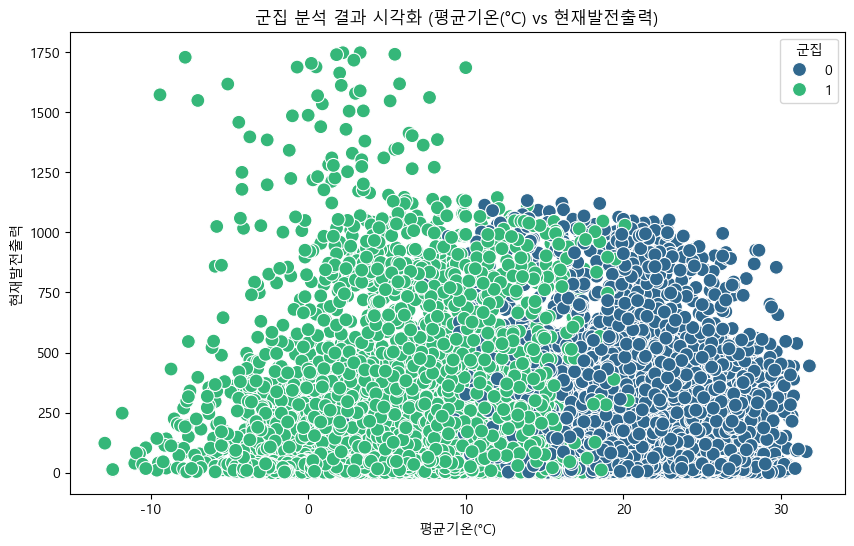

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 분석에 사용할 컬럼 선택
features = ['현재발전출력', '평균기온(°C)', '강수 계속시간(hr)', 
            '1시간 최다강수량(mm)', '일강수량(mm)', '가조시간(hr)', 
            '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
            '평균 지면온도(°C)', '수평일사량', '경사일사량', '외기온도']

# 결측값 제거
df_cleaned = df.dropna(subset=features)

# 피처 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cleaned[features])

# K-Means 모델 생성 및 학습
kmeans = KMeans(n_clusters=2, random_state=42)
df_cleaned['군집'] = kmeans.fit_predict(scaled_features)

# 2차원 공간에서 군집 시각화 (평균기온(°C)와 현재발전출력 사용)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='평균기온(°C)', y='현재발전출력', hue='군집', palette='viridis', s=100)
plt.title('군집 분석 결과 시각화 (평균기온(°C) vs 현재발전출력)')
plt.xlabel('평균기온(°C)')
plt.ylabel('현재발전출력')
plt.legend(title='군집')
plt.show()

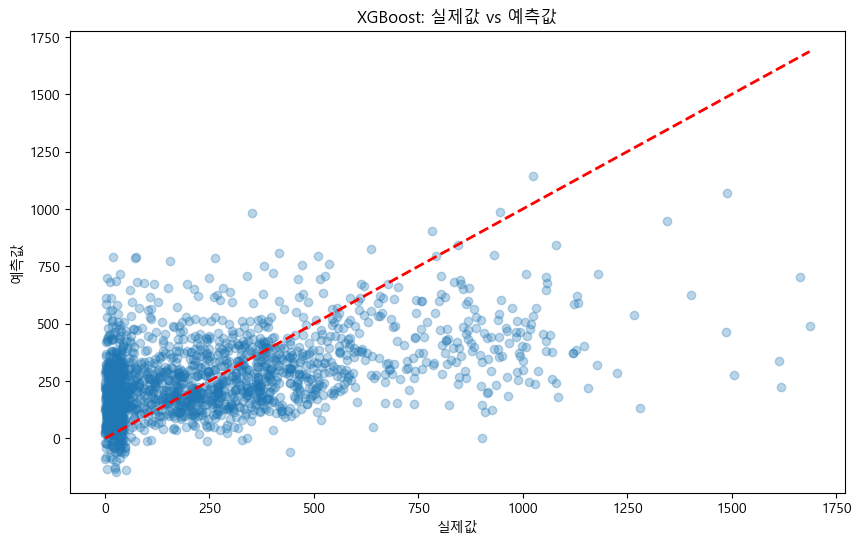

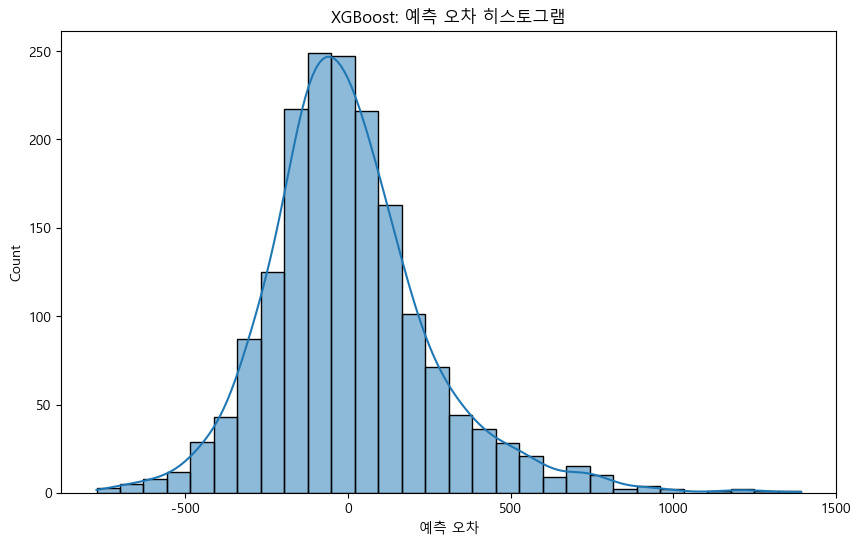

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 실제값과 예측값 비교 산점도
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('XGBoost: 실제값 vs 예측값')
plt.show()

# 예측 오차 히스토그램
errors_xgb = y_test - y_pred_xgb
plt.figure(figsize=(10, 6))
sns.histplot(errors_xgb, bins=30, kde=True)
plt.xlabel('예측 오차')
plt.title('XGBoost: 예측 오차 히스토그램')
plt.show()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '날짜' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 시계열 데이터 확인
print(df.head())

            위치      현재발전출력  계절  평균기온(°C)  강수 계속시간(hr)  1시간 최다강수량(mm)  \
일자                                                                     
2019-01-01  당진  110.657369  겨울      -1.8          0.0            0.0   
2019-01-02  당진  328.857233  겨울      -4.7          0.0            0.0   
2019-01-03  당진  344.740215  겨울      -4.1          0.0            0.0   
2019-01-04  당진  359.595589  겨울      -2.8          0.0            0.0   
2019-01-05  당진  358.737685  겨울      -2.2          0.0            0.0   

            일강수량(mm)  가조시간(hr)  합계 일조시간(hr)  평균 전운량(1/10)  평균 중하층운량(1/10)  \
일자                                                                          
2019-01-01       0.5       9.7          2.0           6.6             0.0   
2019-01-02       0.0       9.7          8.9           1.3             0.0   
2019-01-03       0.0       9.7          9.1           0.4             0.0   
2019-01-04       0.0       9.7          0.8           4.6             0.0   
2019-01-05       0.0       9.7   

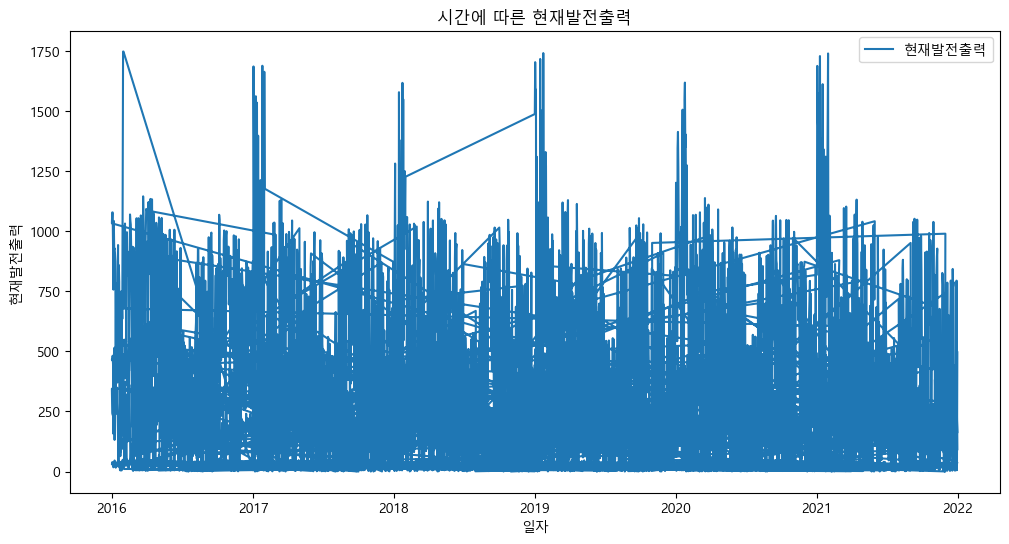

In [9]:
# 시계열 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['현재발전출력'], label='현재발전출력')
plt.xlabel('일자')
plt.ylabel('현재발전출력')
plt.title('시간에 따른 현재발전출력')
plt.legend()
plt.show()

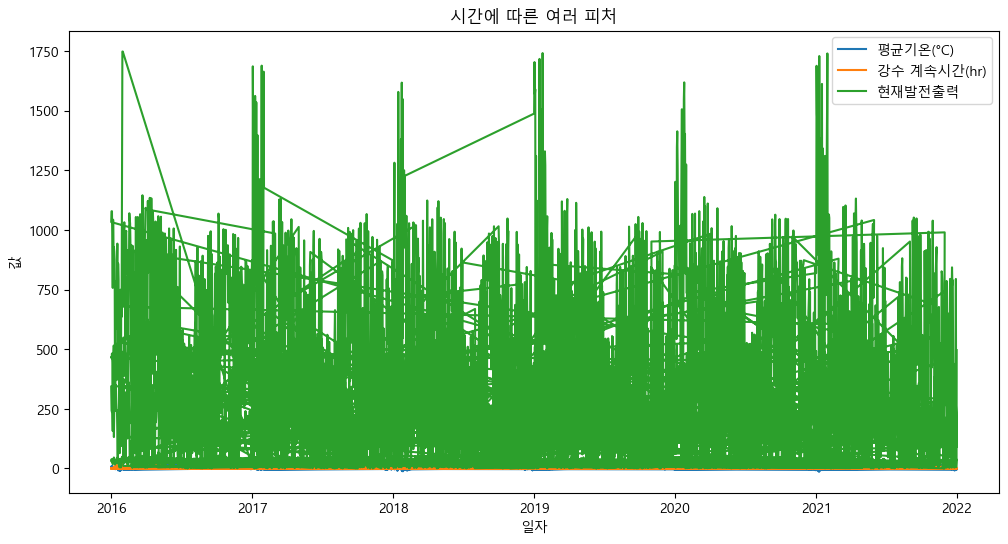

In [10]:
# 여러 피처 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['평균기온(°C)'], label='평균기온(°C)')
plt.plot(df.index, df['강수 계속시간(hr)'], label='강수 계속시간(hr)')
plt.plot(df.index, df['현재발전출력'], label='현재발전출력')
plt.xlabel('일자')
plt.ylabel('값')
plt.title('시간에 따른 여러 피처')
plt.legend()
plt.show()

# 시계열

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0083 - val_loss: 0.0446
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0043 - val_loss: 0.0366
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0043 - val_loss: 0.0450
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0044 - val_loss: 0.0371
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0042 - val_loss: 0.0383
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0044 - val_loss: 0.0388
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0045 - val_loss: 0.0402
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0044 - val_loss: 0.0362
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0044 - val_loss: 0.0358
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0042 - val_loss: 0.0370
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0044 - val_loss: 0.0349
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 

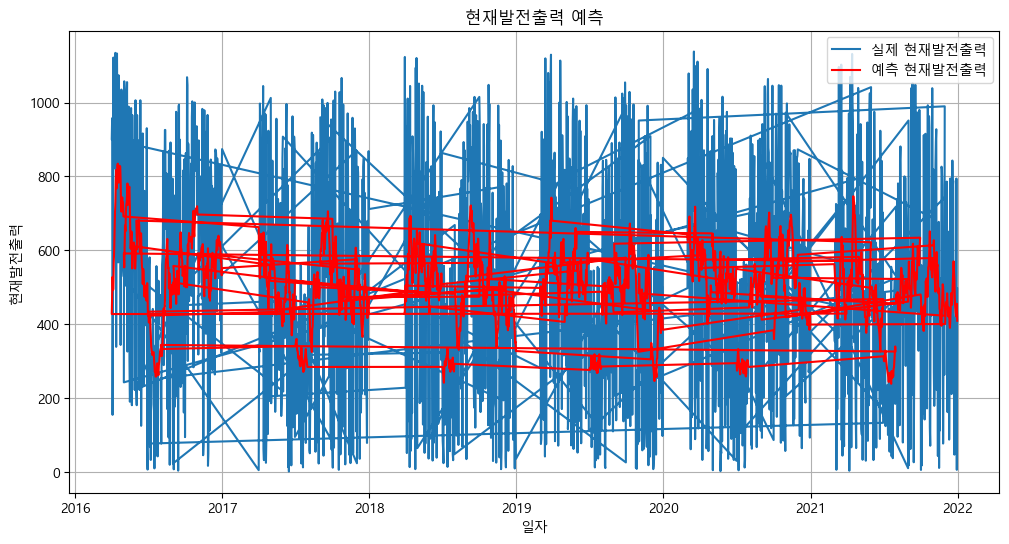

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 필요한 열만 선택
data = df[['현재발전출력']]

# 데이터 전처리: 결측치 처리
data = data.ffill()  # 결측치 처리: 앞의 값으로 대체

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# 데이터 준비: 시퀀스 생성
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# X의 차원 변환 (LSTM의 입력은 [samples, time steps, features] 형식)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 데이터 분리: 학습용과 테스트용
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM 모델 정의
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# 예측
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_inv, label='실제 현재발전출력')
plt.plot(df.index[-len(y_test):], y_pred_inv, label='예측 현재발전출력', color='red')
plt.xlabel('일자')
plt.ylabel('현재발전출력')
plt.title('현재발전출력 예측')
plt.legend()
plt.grid(True)
plt.savefig('image.png', dpi=300)  
plt.show()

In [10]:
# R^2 계산
r2 = r2_score(y_test_inv, y_pred_inv)
print(f'R^2 Score: {r2:.2f}')

# 성능 평가
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE: {rmse:.2f}')

R^2 Score: 0.05
RMSE: 297.27


# 일자와 평균기온에 따른 현재발전출력 예측

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '날짜' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 필요한 열만 선택
data = df[['평균기온(°C)', '현재발전출력']]

In [37]:
# ARIMA 모델 학습
model = ARIMA(data['현재발전출력'], order=(5, 1, 0))
model_fit = model.fit()

# 예측 (향후 30일)
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# 예측 결과를 데이터프레임으로 변환
forecast_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, inclusive='right')
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=['예측값'])

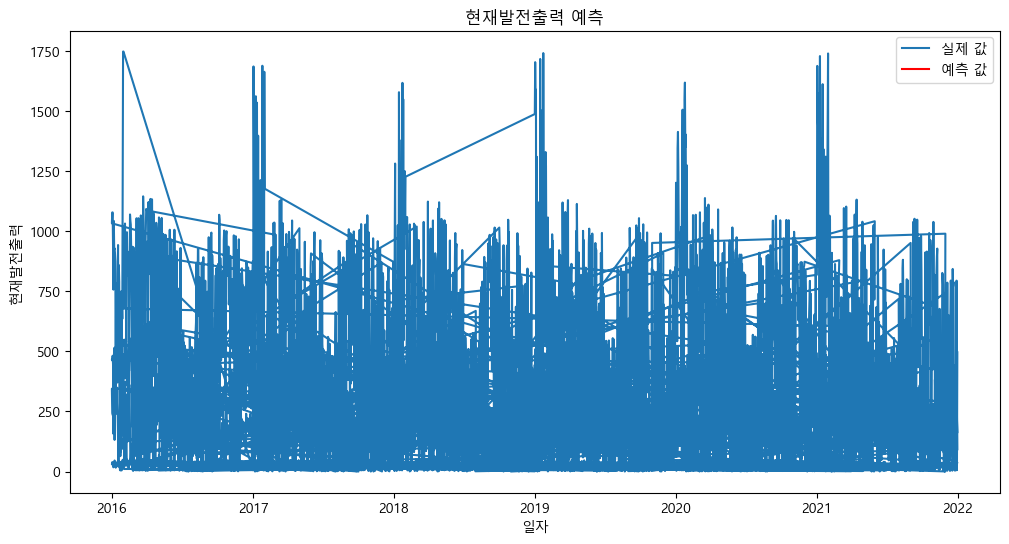

In [38]:
# 실제 값과 예측 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['현재발전출력'], label='실제 값')
plt.plot(forecast_df.index, forecast_df['예측값'], label='예측 값', color='red')
plt.xlabel('일자')
plt.ylabel('현재발전출력')
plt.title('현재발전출력 예측')
plt.legend()
plt.show()

Mean Squared Error: 79156.21800880873
R^2 Score: 0.021641364385672546


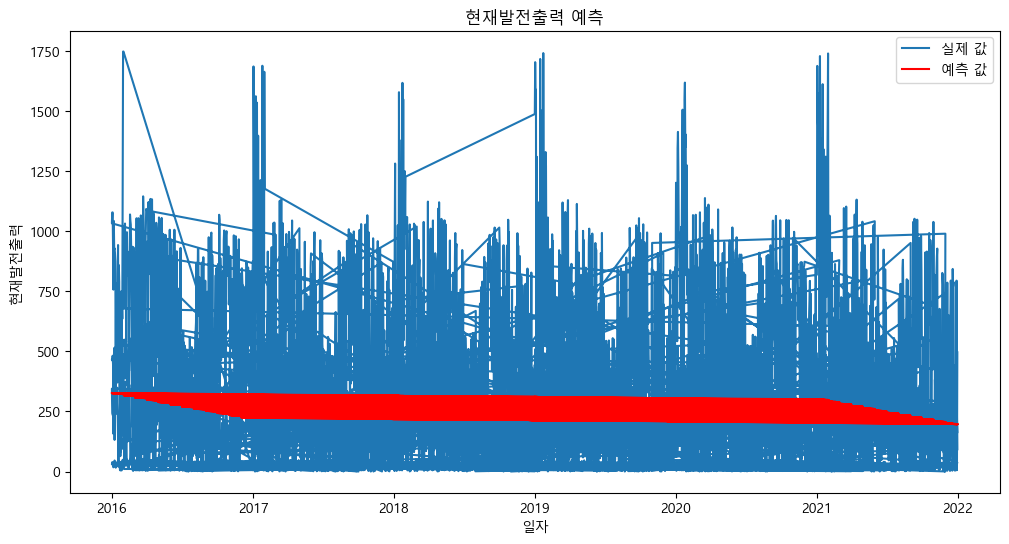

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 피쳐와 타겟 변수 선택
X = df[['평균기온(°C)']]
y = df['현재발전출력']

# 데이터 전처리: 결측치 처리
X = X.fillna(0)  # 결측치 처리: 0으로 대체 (필요에 따라 다른 처리 방식 사용 가능)
y = y.fillna(0)  # 결측치 처리

# 날짜를 연도, 월, 일로 변환하여 피쳐로 추가
X['연도'] = X.index.year
X['월'] = X.index.month
X['일'] = X.index.day

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['평균기온(°C)', '연도', '월', '일']])

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 전체 데이터에 대해 예측
y_all_pred = model.predict(X_scaled)

# 예측 결과를 원본 데이터와 합침
df['예측값'] = y_all_pred

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['현재발전출력'], label='실제 값')
plt.plot(df.index, df['예측값'], label='예측 값', color='red')
plt.xlabel('일자')
plt.ylabel('현재발전출력')
plt.title('현재발전출력 예측')
plt.legend()
plt.show()

Mean Squared Error: 85100.2924571234
R^2 Score: -0.051826478236570495


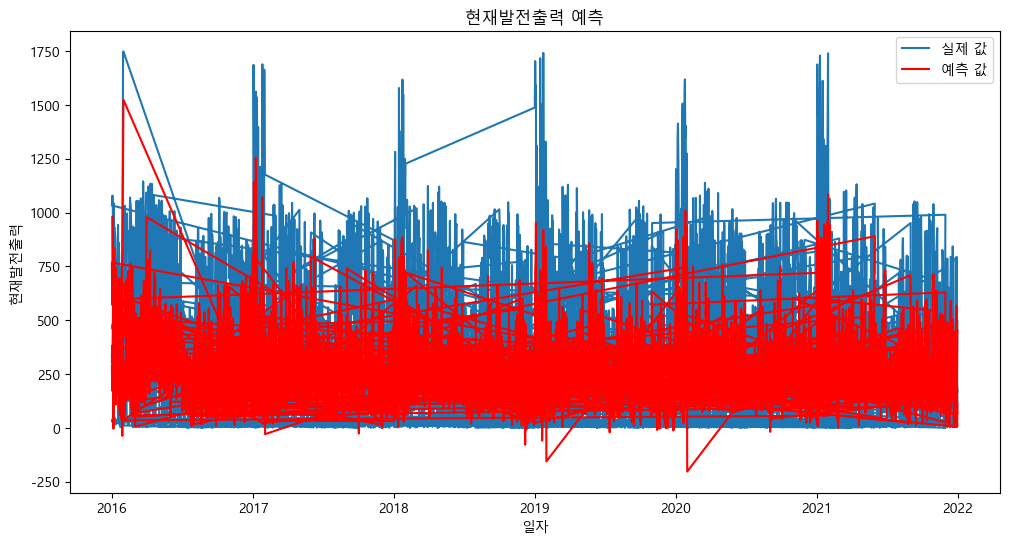

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '날짜' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 피쳐와 타겟 변수 선택
X = df[['평균기온(°C)']]
y = df['현재발전출력']

# 데이터 전처리: 결측치 처리
X = X.fillna(0)  # 결측치 처리: 0으로 대체 (필요에 따라 다른 처리 방식 사용 가능)
y = y.fillna(0)  # 결측치 처리

# 날짜를 연도, 월, 일로 변환하여 피쳐로 추가
X['연도'] = X.index.year
X['월'] = X.index.month
X['일'] = X.index.day

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['평균기온(°C)', '연도', '월', '일']])

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 전체 데이터에 대해 예측
y_all_pred = model.predict(X_scaled)

# 예측 결과를 원본 데이터와 합침
df['예측값'] = y_all_pred

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['현재발전출력'], label='실제 값')
plt.plot(df.index, df['예측값'], label='예측 값', color='red')
plt.xlabel('일자')
plt.ylabel('현재발전출력')
plt.title('현재발전출력 예측')
plt.legend()
plt.show()

Mean Squared Error: 76659.32471699402
R^2 Score: 0.05250258003878239


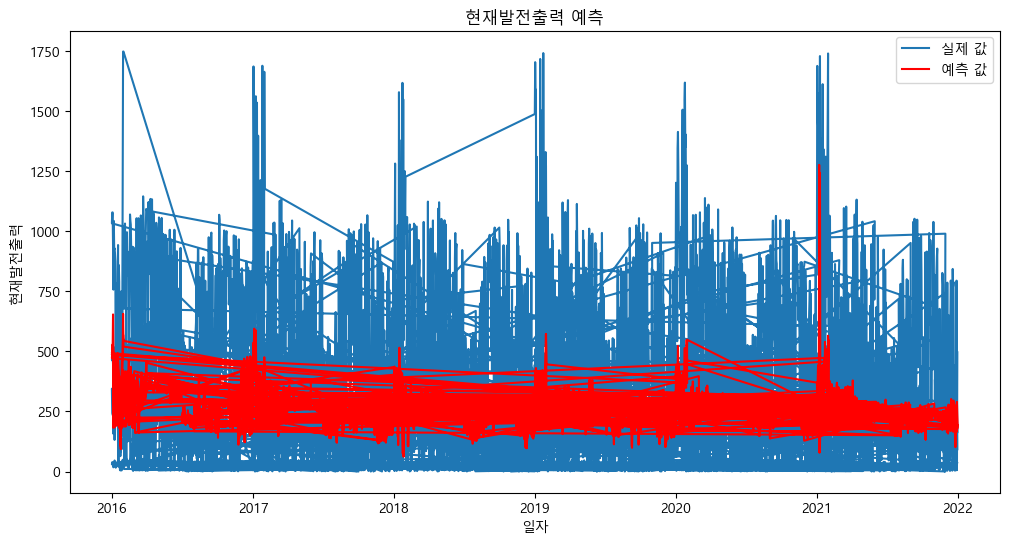

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# 피쳐와 타겟 변수 선택
X = df[['평균기온(°C)']]
y = df['현재발전출력']

# 데이터 전처리: 결측치 처리
X = X.fillna(0)  # 결측치 처리: 0으로 대체 (필요에 따라 다른 처리 방식 사용 가능)
y = y.fillna(0)  # 결측치 처리

# 날짜를 연도, 월, 일로 변환하여 피쳐로 추가
X['연도'] = X.index.year
X['월'] = X.index.month
X['일'] = X.index.day

# 특성 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['평균기온(°C)', '연도', '월', '일']])

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Gradient Boosting 모델 학습
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 전체 데이터에 대해 예측
y_all_pred = model.predict(X_scaled)

# 예측 결과를 원본 데이터와 합침
df['예측값'] = y_all_pred

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['현재발전출력'], label='실제 값')
plt.plot(df.index, df['예측값'], label='예측 값', color='red')
plt.xlabel('일자')
plt.ylabel('현재발전출력')
plt.title('현재발전출력 예측')
plt.legend()
plt.show()

# 경사일사량, 수평일사량에 따른 현재발전출력(시계열)

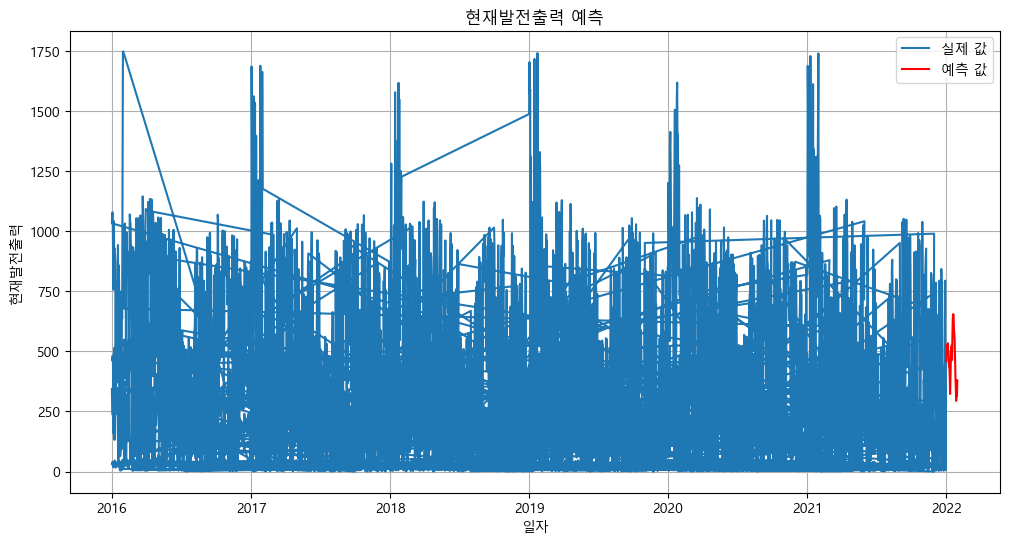

R^2 Score: 0.10


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def train_and_evaluate_time_series_model():
    # 데이터 불러오기
    df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

    # '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
    df['일자'] = pd.to_datetime(df['일자'])
    df.set_index('일자', inplace=True)

    # 필요한 열만 선택
    data = df[['경사일사량', '수평일사량', '현재발전출력']]

    # 데이터 전처리: 결측치 처리
    data = data.fillna(method='ffill')  # 결측치 처리: 앞의 값으로 대체

    # 단순 이동 평균 계산 (window=7)
    data['SMA'] = data['현재발전출력'].rolling(window=7).mean()

    # 예측 (향후 30일)
    forecast_steps = 30
    forecast = data['SMA'].iloc[-forecast_steps:].values

    # 예측 결과를 데이터프레임으로 변환
    forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=['예측값'])

    # 실제 값과 예측 값 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['현재발전출력'], label='실제 값')
    plt.plot(forecast_df.index, forecast_df['예측값'], label='예측 값', color='red')
    plt.xlabel('일자')
    plt.ylabel('현재발전출력')
    plt.title('현재발전출력 예측')
    plt.legend()
    plt.grid(True)
    plt.savefig('time_series_forecast.png', dpi=300)
    plt.show()

    # R^2 계산
    # 예측 기간 동안의 실제 값이 필요합니다. 여기서는 예시로 실제 값을 생성합니다.
    actual_values = data['현재발전출력'][-forecast_steps:].values  # 예측 기간 동안의 실제 값
    r2 = r2_score(actual_values, forecast)
    print(f'R^2 Score: {r2:.2f}')

# 시계열 모델 학습 및 평가
train_and_evaluate_time_series_model()

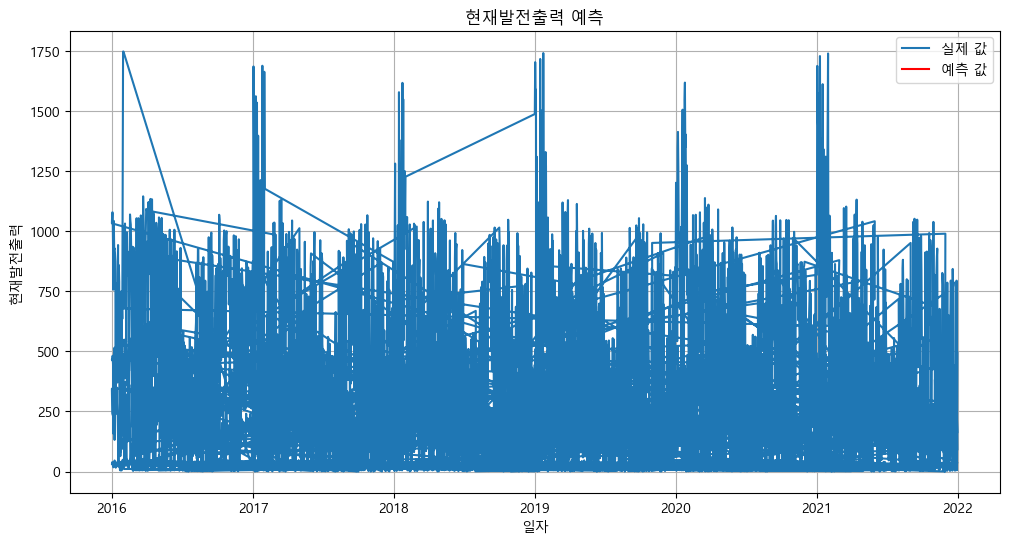

R^2 Score: -0.03


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

def train_and_evaluate_time_series_model():
    # 데이터 불러오기
    df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

    # '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
    df['일자'] = pd.to_datetime(df['일자'])
    df.set_index('일자', inplace=True)

    # 필요한 열만 선택
    data = df[['현재발전출력']]

    # 데이터 전처리: 결측치 처리
    data = data.fillna(method='ffill')  # 결측치 처리: 앞의 값으로 대체

    # ARIMA 모델 학습
    model = ARIMA(data['현재발전출력'], order=(5, 1, 0))  # ARIMA 모델의 차수는 데이터에 따라 조정
    model_fit = model.fit()

    # 예측 (향후 30일)
    forecast_steps = 30
    forecast = model_fit.forecast(steps=forecast_steps)

    # 예측 결과를 데이터프레임으로 변환
    forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=['예측값'])

    # 실제 값과 예측 값 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['현재발전출력'], label='실제 값')
    plt.plot(forecast_df.index, forecast_df['예측값'], label='예측 값', color='red')
    plt.xlabel('일자')
    plt.ylabel('현재발전출력')
    plt.title('현재발전출력 예측')
    plt.legend()
    plt.grid(True)
    plt.savefig('time_series_forecast.png', dpi=300)
    plt.show()

    # R^2 계산
    # 예측 기간 동안의 실제 값이 필요합니다. 여기서는 예시로 실제 값을 생성합니다.
    actual_values = data['현재발전출력'][-forecast_steps:].values  # 예측 기간 동안의 실제 값
    r2 = r2_score(actual_values, forecast)
    print(f'R^2 Score: {r2:.2f}')

# 시계열 모델 학습 및 평가
train_and_evaluate_time_series_model()

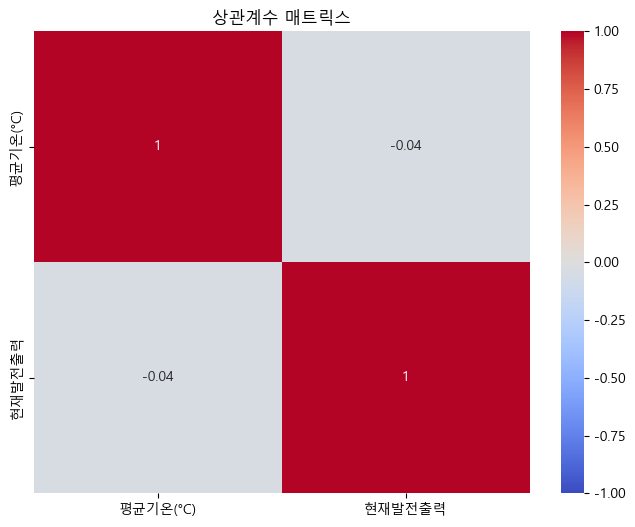

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_and_plot_correlations():
    # 데이터 불러오기
    df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

    # '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
    df['일자'] = pd.to_datetime(df['일자'])
    df.set_index('일자', inplace=True)

    # 필요한 열만 선택
    data = df[['평균기온(°C)', '현재발전출력']]

    # 데이터 전처리: 결측치 처리
    data = data.fillna(method='ffill')  # 결측치 처리: 앞의 값으로 대체

    # 상관계수 계산
    correlation_matrix = data.corr()

    # 상관계수 매트릭스 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('상관계수 매트릭스')
    plt.show()

# 상관계수 계산 및 시각화
calculate_and_plot_correlations()


Mean Squared Error: 78480.9654535594
R^2 Score: 0.029987381732980767


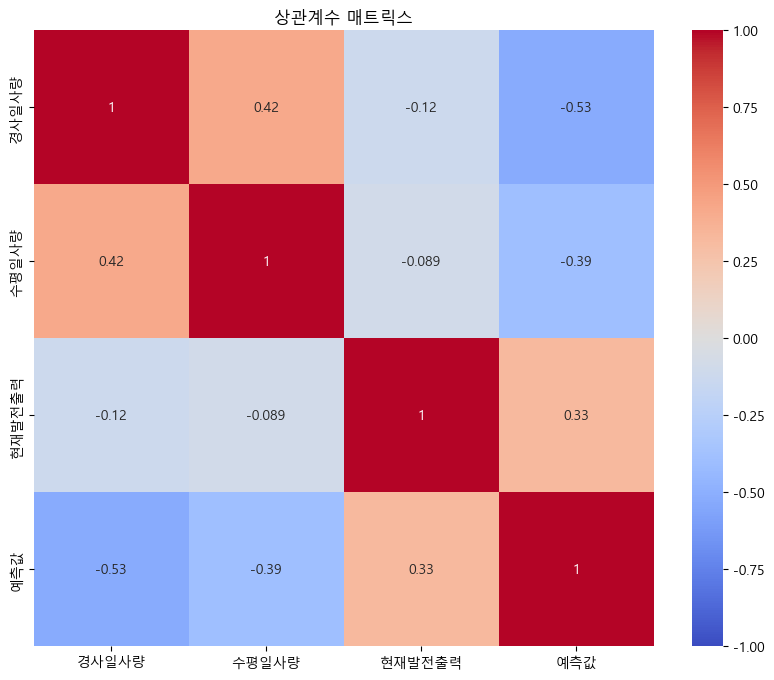

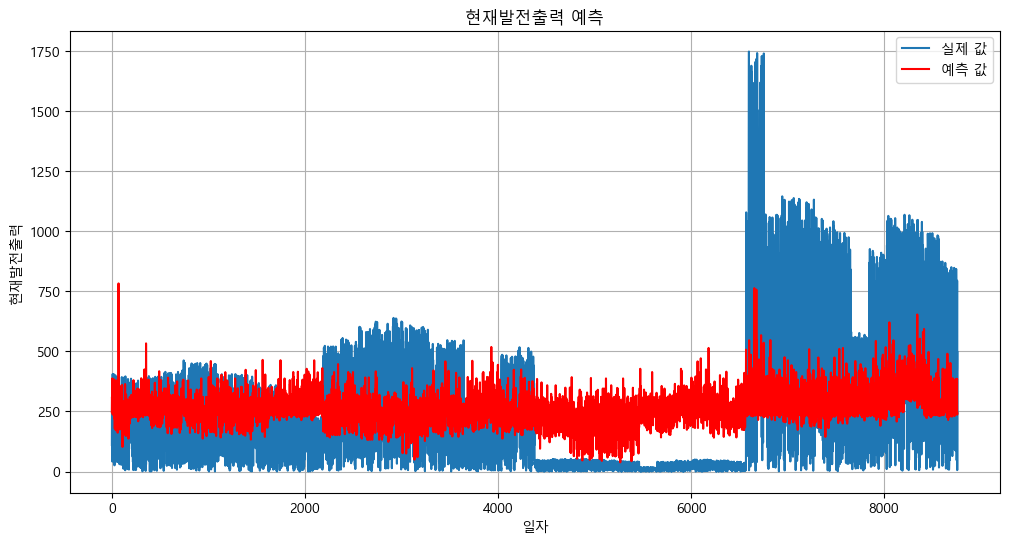

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(features):
    # 데이터 불러오기
    df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

    # 피쳐와 타겟 변수 선택
    X = df[features]
    y = df['현재발전출력']

    # 데이터 전처리: 결측치 처리
    X = X.fillna(0)  # 결측치 처리: 0으로 대체 (필요에 따라 다른 처리 방식 사용 가능)
    y = y.fillna(0)  # 결측치 처리

    # 특성 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 데이터 분리: 학습용과 테스트용
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Gradient Boosting 모델 학습
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 평가
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

    # 전체 데이터에 대해 예측
    y_all_pred = model.predict(X_scaled)

    # 예측 결과를 원본 데이터와 합침
    df['예측값'] = y_all_pred

    # 상관계수 계산
    correlation_matrix = df[['경사일사량', '수평일사량', '현재발전출력', '예측값']].corr()

    # 상관계수 매트릭스 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('상관계수 매트릭스')
    plt.show()

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['현재발전출력'], label='실제 값')
    plt.plot(df.index, df['예측값'], label='예측 값', color='red')
    plt.xlabel('일자')
    plt.ylabel('현재발전출력')
    plt.title('현재발전출력 예측')
    plt.legend()
    plt.grid(True)
    plt.show()

# 사용자 입력으로 경사일사량과 수평일사량을 선택할 수 있도록 설정
features = ['경사일사량', '수평일사량']
train_and_evaluate_model(features)

# 지역 파생변수 생성

In [16]:
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')
location_mapping = {'당진': 1, '울산': 2, '영광': 3, '동해': 4}
df['위치코드'] = df['위치'].map(location_mapping)
df.head()

,위치,일자,현재발전출력,계절,평균기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),가조시간(hr),합계 일조시간(hr),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),수평일사량,경사일사량,외기온도,위치코드
0,당진,2019-01-01,110.657369,겨울,-1.8,0.0,0.0,0.5,9.7,2.0,6.6,0.0,-0.9,140.287481,146.321291,15.134762,1
1,당진,2019-01-02,328.857233,겨울,-4.7,0.0,0.0,0.0,9.7,8.9,1.3,0.0,-1.6,362.764802,394.670819,15.261386,1
2,당진,2019-01-03,344.740215,겨울,-4.1,0.0,0.0,0.0,9.7,9.1,0.4,0.0,-1.6,406.199640,440.304715,15.798569,1
3,당진,2019-01-04,359.595589,겨울,-2.8,0.0,0.0,0.0,9.7,0.8,4.6,0.0,-1.8,371.371608,393.879843,16.018869,1
4,당진,2019-01-05,358.737685,겨울,-2.2,0.0,0.0,0.0,9.7,9.0,3.6,0.0,-0.7,337.086489,358.857070,16.719318,1


In [7]:
# # CSV 파일로 추출
# file_path = 'C:/Users/campus4D045/Desktop/기계학습/weather1.csv'
# df.to_csv(file_path, index=False, encoding='utf-8')

# # 확인 메시지 출력
# print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/기계학습/weather1.csv 경로에 저장되었습니다.


# dd

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 로드
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 특성 및 타겟 변수 정의
X = df[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', '가조시간(hr)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df['현재발전출력']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# 중요 특성 확인
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

Mean Squared Error: 63128.92
R^2 Score: 0.22

Feature Importance:
           Feature  Importance
8      평균 지면온도(°C)    0.139173
10           경사일사량    0.134818
11            외기온도    0.130805
9            수평일사량    0.130598
0         평균기온(°C)    0.118009
4         가조시간(hr)    0.092474
5      합계 일조시간(hr)    0.075783
6     평균 전운량(1/10)    0.072469
7   평균 중하층운량(1/10)    0.057047
3         일강수량(mm)    0.024478
1      강수 계속시간(hr)    0.013400
2    1시간 최다강수량(mm)    0.010945


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 데이터 로드
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 특성 및 타겟 변수 정의
X = df[['위치코드','평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', '가조시간(hr)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df['현재발전출력']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 훈련
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 선형 회귀 모델 훈련
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 예측
rf_y_pred = rf_model.predict(X_test)
lr_y_pred = lr_model.predict(X_test)

# 성능 평가
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f"Random Forest Regressor:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"R^2 Score: {rf_r2:.2f}")

print(f"\nLinear Regression:")
print(f"Mean Squared Error: {lr_mse:.2f}")
print(f"R^2 Score: {lr_r2:.2f}")

# 랜덤 포레스트 모델의 중요 특성 확인
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importance from Random Forest:")
print(importance_df)

Random Forest Regressor:
Mean Squared Error: 36313.87
R^2 Score: 0.55

Linear Regression:
Mean Squared Error: 66832.99
R^2 Score: 0.17

Feature Importance from Random Forest:
           Feature  Importance
0             위치코드    0.472280
10           수평일사량    0.091331
11           경사일사량    0.081544
12            외기온도    0.064108
5         가조시간(hr)    0.061017
9      평균 지면온도(°C)    0.059999
1         평균기온(°C)    0.050382
6      합계 일조시간(hr)    0.042658
7     평균 전운량(1/10)    0.030553
8   평균 중하층운량(1/10)    0.023197
4         일강수량(mm)    0.012752
3    1시간 최다강수량(mm)    0.007056
2      강수 계속시간(hr)    0.003124


In [65]:
df.head()

,위치,일자,현재발전출력,계절,평균기온(°C),강수 계속시간(hr),1시간 최다강수량(mm),일강수량(mm),가조시간(hr),합계 일조시간(hr),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),수평일사량,경사일사량,외기온도,위치코드
0,당진,2019-01-01,110.657369,겨울,-1.8,0.0,0.0,0.5,9.7,2.0,6.6,0.0,-0.9,140.287481,146.321291,15.134762,1
1,당진,2019-01-02,328.857233,겨울,-4.7,0.0,0.0,0.0,9.7,8.9,1.3,0.0,-1.6,362.764802,394.670819,15.261386,1
2,당진,2019-01-03,344.740215,겨울,-4.1,0.0,0.0,0.0,9.7,9.1,0.4,0.0,-1.6,406.199640,440.304715,15.798569,1
3,당진,2019-01-04,359.595589,겨울,-2.8,0.0,0.0,0.0,9.7,0.8,4.6,0.0,-1.8,371.371608,393.879843,16.018869,1
4,당진,2019-01-05,358.737685,겨울,-2.2,0.0,0.0,0.0,9.7,9.0,3.6,0.0,-0.7,337.086489,358.857070,16.719318,1


# 평균지면온도와 경사일사량의 값에 따라 현재 발전출력 예측(랜덤포레스트)

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 데이터 로드
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 특성 및 타겟 변수 정의
X = df[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', '가조시간(hr)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df['현재발전출력']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 평균 지면온도(°C)와 경사일사량 값을 입력 받아 예측하는 함수
def predict_power_output(ground_temp, inclined_irradiance):
    # 입력된 두 특성만 사용하여 예측할 수 있도록 나머지 특성은 고정
    X_new = pd.DataFrame({
        '평균기온(°C)': [X['평균기온(°C)'].mean()],   # 다른 특성들은 데이터셋의 평균값으로 설정
        '강수 계속시간(hr)': [X['강수 계속시간(hr)'].mean()],
        '1시간 최다강수량(mm)': [X['1시간 최다강수량(mm)'].mean()],
        '일강수량(mm)': [X['일강수량(mm)'].mean()],
        '가조시간(hr)': [X['가조시간(hr)'].mean()],
        '합계 일조시간(hr)': [X['합계 일조시간(hr)'].mean()],
        '평균 전운량(1/10)': [X['평균 전운량(1/10)'].mean()],
        '평균 중하층운량(1/10)': [X['평균 중하층운량(1/10)'].mean()],
        '평균 지면온도(°C)': [ground_temp],            # 입력된 지면온도
        '수평일사량': [X['수평일사량'].mean()],
        '경사일사량': [inclined_irradiance],          # 입력된 경사일사량
        '외기온도': [X['외기온도'].mean()]
    })

    # 현재발전출력 예측
    predicted_output = model.predict(X_new)

    return predicted_output[0]

# 예측 예시
ground_temp = 25.0  # 예시: 평균 지면온도 25°C
inclined_irradiance = 800.0  # 예시: 경사일사량 800 W/m²

predicted_power = predict_power_output(ground_temp, inclined_irradiance)
print(f"Predicted Power Output: {predicted_power:.2f}")

Predicted Power Output: 157.91


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 성능 평가 (MSE 및 R² Score)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R² Score: {r2:.2f}')

Mean Squared Error: 63154.22
R² Score: 0.22


# 평균 지면온도와 경사일사량에 따라 위치코드 예측

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 데이터 로드 (데이터가 이미 로드되어 있다고 가정)
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 특성(X)과 타겟(y) 정의
X = df[['평균 지면온도(°C)', '경사일사량']]
y = df['위치코드']

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 분류 모델 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 위치코드를 예측하는 함수
def predict_location(ground_temp, inclined_irradiance):
    input_data = pd.DataFrame({
        '평균 지면온도(°C)': [ground_temp],
        '경사일사량': [inclined_irradiance]
    })
    
    predicted_code = model.predict(input_data)
    
    # 위치코드에서 실제 위치(A, B, C, D)로 변환
    reverse_mapping = {v: k for k, v in location_mapping.items()}
    predicted_location = reverse_mapping[predicted_code[0]]
    
    return predicted_location

# 예측 예시
ground_temp = 20.0  # 예시: 평균 지면온도 25°C
inclined_irradiance = 400.0  # 예시: 경사일사량 800 W/m²

predicted_location = predict_location(ground_temp, inclined_irradiance)
print(f"Predicted Location: {predicted_location}")

Accuracy: 0.34
Predicted Location: 울산


Accuracy: 0.34

Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.32      0.33       453
           2       0.33      0.34      0.33       417
           3       0.34      0.32      0.33       449
           4       0.37      0.40      0.38       433

    accuracy                           0.34      1752
   macro avg       0.34      0.35      0.34      1752
weighted avg       0.34      0.34      0.34      1752



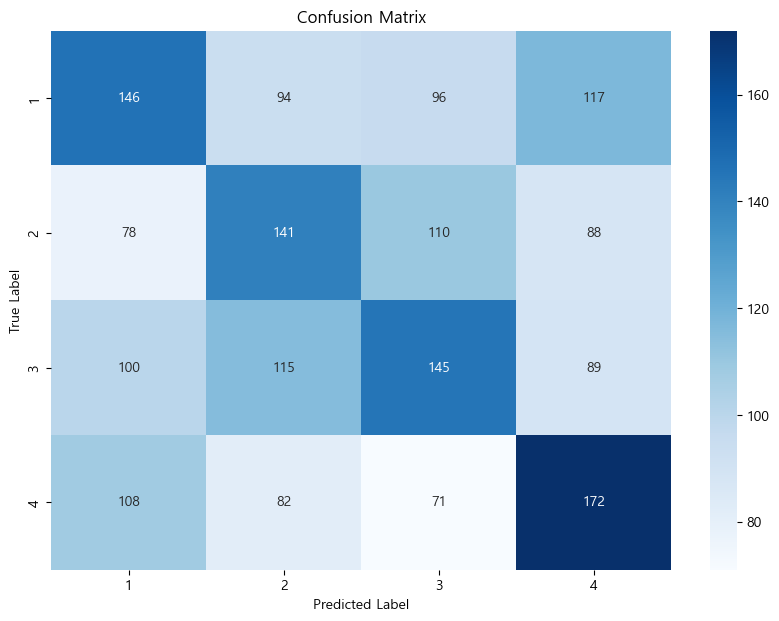

Predicted Location: D


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드 (데이터가 이미 로드되어 있다고 가정)
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 특성(X)과 타겟(y) 정의
X = df[['평균 지면온도(°C)', '경사일사량']]
y = df['위치코드']

# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 분류 모델 훈련
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 위치코드를 예측하는 함수
def predict_location(ground_temp, inclined_irradiance):
    input_data = pd.DataFrame({
        '평균 지면온도(°C)': [ground_temp],
        '경사일사량': [inclined_irradiance]
    })
    
    predicted_code = model.predict(input_data)
    
    # 위치코드에서 실제 위치(A, B, C, D)로 변환
    reverse_mapping = {v: k for k, v in location_mapping.items()}
    predicted_location = reverse_mapping[predicted_code[0]]
    
    return predicted_location

# 위치코드 맵핑
location_mapping = {
    'A': 0,  # 예시로 위치코드에 매핑된 숫자
    'B': 1,
    'C': 2,
    'D': 3
}

# 예측 예시
ground_temp = 25.0  # 예시: 평균 지면온도 25°C
inclined_irradiance = 800.0  # 예시: 경사일사량 800 W/m²

predicted_location = predict_location(ground_temp, inclined_irradiance)
print(f"Predicted Location: {predicted_location}")

# 랜덤포레스트 시각화 / 위치 추가 X

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 피처와 타겟 변수 분리
X = df[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', '가조시간(hr)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df['현재발전출력']

# 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred_rf = rf_model.predict(X_test)

# 성능 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

Random Forest MSE: 63154.21943952497
Random Forest R^2: 0.21942359654846588


Random Forest MSE: 63154.21943952497
Random Forest R^2: 0.21942359654846588


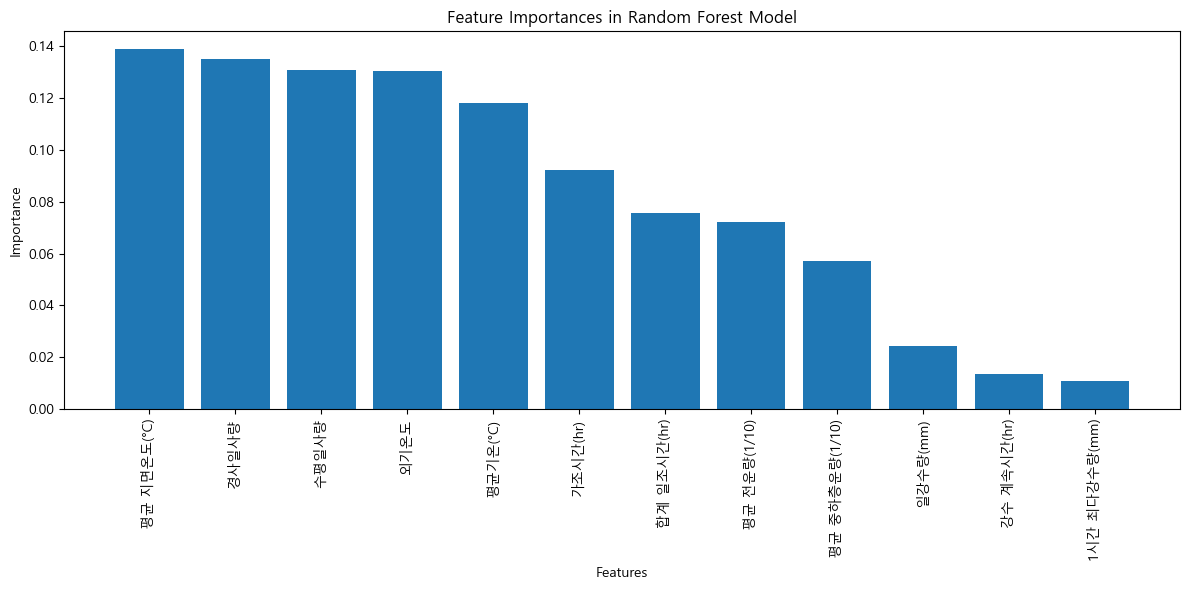

<Figure size 640x480 with 0 Axes>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# 성능 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

# 1. 피처 중요도 바 차트
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest Model')

plt.tight_layout()  
plt.savefig('feature_importances.png', dpi=300)  
plt.show()

# 2. 예측 오차 바 차트
residuals = y_test - y_pred_rf
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf, 'Residual': residuals})
residuals_df = residuals_df.reset_index(drop=True)

residuals_melted = residuals_df.melt(id_vars=['Actual'], value_vars=['Residual'],
                                      var_name='Type', value_name='Value')

plt.tight_layout()  
plt.savefig('prediction_residuals.png', dpi=300)  
plt.show()

# 랜덤포레스트 시각화 / 위치 추가 O

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# 피처와 타겟 변수 분리
X = df[['위치코드','평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', '가조시간(hr)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', '평균 지면온도(°C)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df['현재발전출력']

# 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 모델 학습
rf_model.fit(X_train, y_train)

# 예측
y_pred_rf = rf_model.predict(X_test)

# 성능 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

Random Forest MSE: 36313.87000365483
Random Forest R^2: 0.5511661723568182


Random Forest MSE: 36313.87000365483
Random Forest R^2: 0.5511661723568182


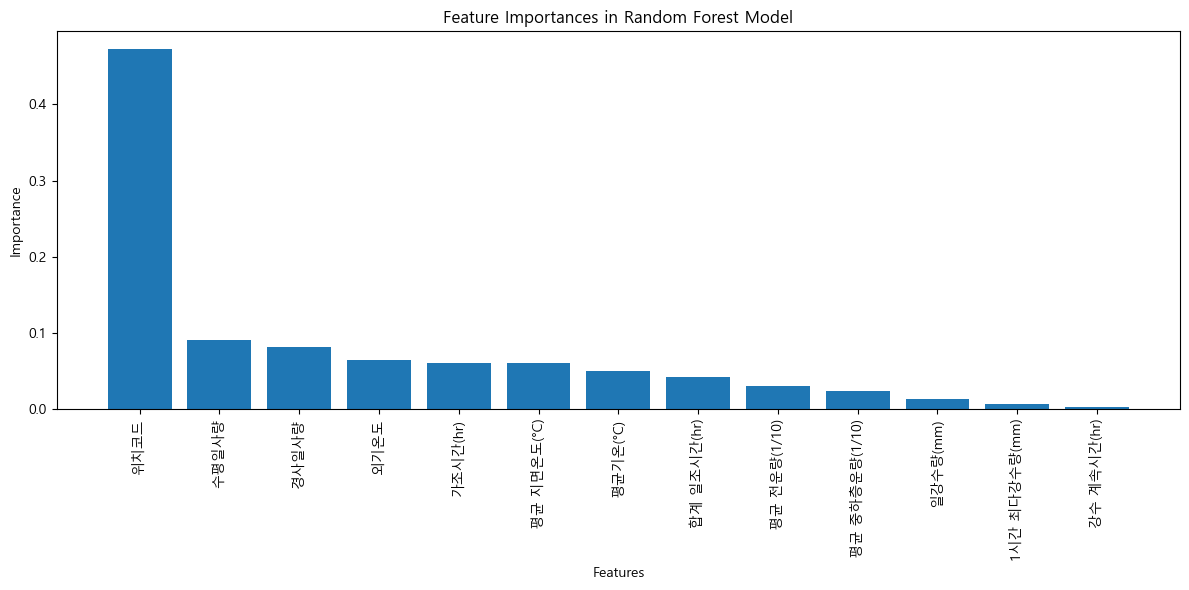

<Figure size 640x480 with 0 Axes>

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# 성능 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

# 1. 피처 중요도 바 차트
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest Model')

plt.tight_layout()  
plt.savefig('feature_importances.png', dpi=300)  
plt.show()

# 2. 예측 오차 바 차트
residuals = y_test - y_pred_rf
residuals_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf, 'Residual': residuals})
residuals_df = residuals_df.reset_index(drop=True)

residuals_melted = residuals_df.melt(id_vars=['Actual'], value_vars=['Residual'],
                                      var_name='Type', value_name='Value')

plt.tight_layout()  
plt.savefig('prediction_residuals.png', dpi=300)  
plt.show()

# 위치별 (로지스틱)

Accuracy: 0.589041095890411
              precision    recall  f1-score   support

           0       0.52      0.42      0.46       741
           1       0.63      0.71      0.67      1011

    accuracy                           0.59      1752
   macro avg       0.57      0.57      0.56      1752
weighted avg       0.58      0.59      0.58      1752

    Feature  Importance
2     경사일사량    0.266284
1     수평일사량    0.263755
3      외기온도    0.247470
0  평균기온(°C)    0.222490


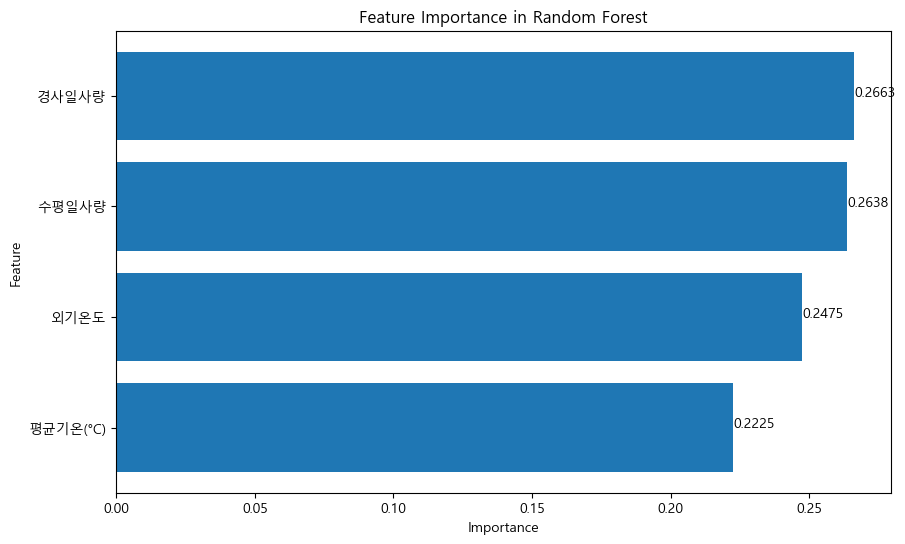

In [23]:
df['효율성'] = (df['현재발전출력'] >= 124.97).astype(int)

X = df[['평균기온(°C)', '수평일사량', '경사일사량', '외기온도']]
y = df['효율성']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')

for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')
plt.gca().invert_yaxis()
plt.show()

C:\Users\campus4D045\AppData\Local\Temp\ipykernel_15144\882924731.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 124.97).astype(int)


Accuracy: 0.8881278538812786
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.89      1.00      0.94       389

    accuracy                           0.89       438
   macro avg       0.44      0.50      0.47       438
weighted avg       0.79      0.89      0.84       438

          Feature  Importance
7           수평일사량    0.001224
8           경사일사량    0.001017
1     강수 계속시간(hr)    0.000000
9            외기온도   -0.000316
3        일강수량(mm)   -0.000406
6  평균 중하층운량(1/10)   -0.006483
5    평균 전운량(1/10)   -0.008823
2   1시간 최다강수량(mm)   -0.012017
0        평균기온(°C)   -0.015946
4     합계 일조시간(hr)   -0.017121


C:\Users\campus4D045\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D045\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D045\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\campus4D045\anaconda3\Lib\si

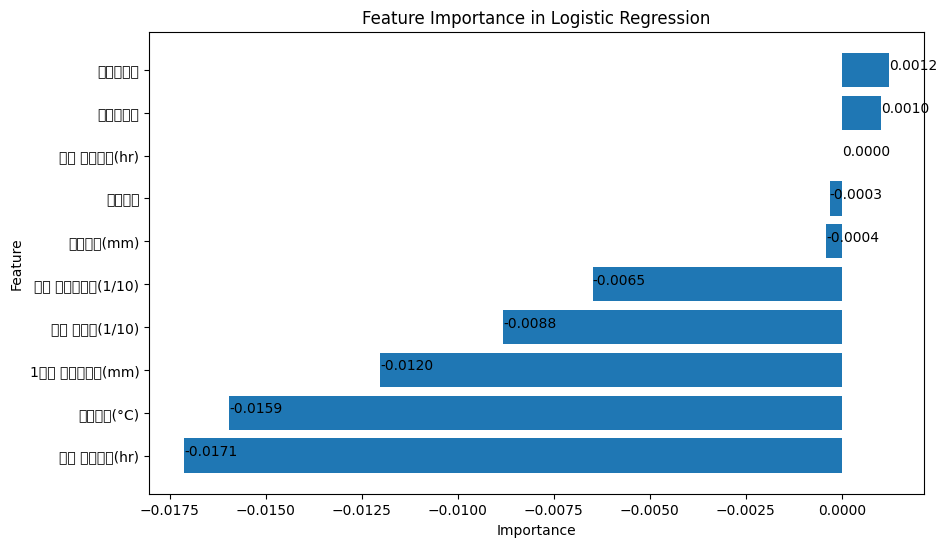

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# '위치'가 울산인 데이터만 선택
df_ulsan = df[df['위치'] == '동해']

# '효율성' 열 추가 (현재발전출력 >= 124.97일 때 1, 그렇지 않으면 0)
df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 124.97).astype(int)

# 특성과 타겟 변수 설정
X = df_ulsan[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df_ulsan['효율성']

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 정의 및 학습
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 계산
# 로지스틱 회귀에서 특성 중요도는 모델의 계수를 사용하여 계산
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')

# 중요도 값 텍스트 추가
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')

plt.gca().invert_yaxis()
plt.show()

In [12]:
df['현재발전출력'].describe()

count    8760.000000
mean      262.222538
std       276.954799
min         0.011619
25%        38.131649
50%       183.750908
75%       385.075204
max      1747.613037
Name: 현재발전출력, dtype: float64

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns = X.columns)

Accuracy: 0.7534246575342466
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       328
           1       0.60      0.05      0.10       110

    accuracy                           0.75       438
   macro avg       0.68      0.52      0.48       438
weighted avg       0.72      0.75      0.67       438

          Feature  Importance
4     합계 일조시간(hr)    0.063358
6  평균 중하층운량(1/10)    0.055952
5    평균 전운량(1/10)    0.023582
1     강수 계속시간(hr)    0.012144
7           수평일사량    0.005946
3        일강수량(mm)    0.005424
8           경사일사량    0.003086
2   1시간 최다강수량(mm)   -0.014045
9            외기온도   -0.015844
0        평균기온(°C)   -0.027879


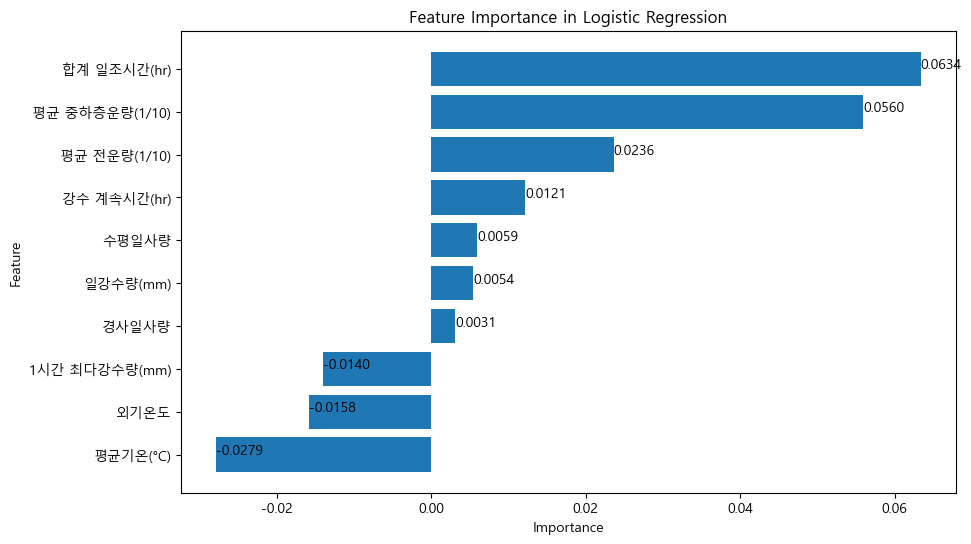

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# '위치'가 울산인 데이터만 선택
df_ulsan = df[df['위치'] == '울산']

# '효율성' 열 추가 (현재발전출력 >= 124.97일 때 1, 그렇지 않으면 0)
df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 417.15).astype(int)

# 특성과 타겟 변수 설정
X = df_ulsan[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df_ulsan['효율성']

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 정의 및 학습 (클래스 가중치 조정)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight={0: 1, 1: 0.5})
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 계산
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')

# 중요도 값 텍스트 추가
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')

plt.gca().invert_yaxis()
plt.show()

Accuracy: 0.8156392694063926
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1473
           1       0.36      0.20      0.26       279

    accuracy                           0.82      1752
   macro avg       0.61      0.57      0.58      1752
weighted avg       0.78      0.82      0.79      1752

          Feature  Importance
6  평균 중하층운량(1/10)    0.329737
9            외기온도    0.039233
3        일강수량(mm)    0.014057
7           수평일사량   -0.000784
4     합계 일조시간(hr)   -0.002094
8           경사일사량   -0.002215
0        평균기온(°C)   -0.014489
2   1시간 최다강수량(mm)   -0.056519
1     강수 계속시간(hr)   -0.110799
5    평균 전운량(1/10)   -0.261438


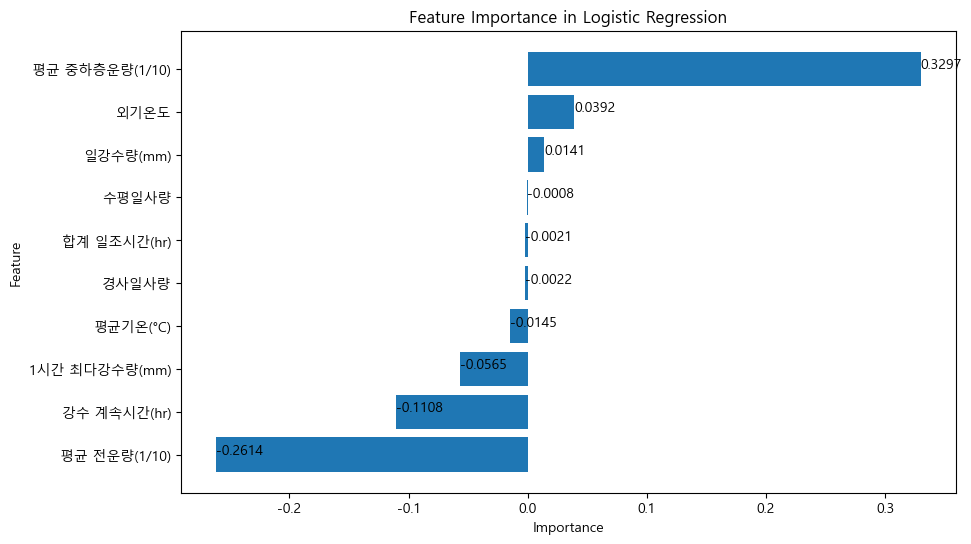

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# '위치'가 울산인 데이터만 선택
# df_ulsan = df[df['위치'] == '당진']

# '위치'가 울산, 당진, 영광, 동해인 데이터만 선택 전체 514 울산 448 당진 321 동해 868
df_ulsan = df[df['위치'].isin(['울산' , '당진' , '영광', '동해' ])] 

# '효율성' 열 추가 (현재발전출력 >= 124.97일 때 1, 그렇지 않으면 0)  417.15
df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 514).astype(int)

# 특성과 타겟 변수 설정
X = df_ulsan[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df_ulsan['효율성']

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 로지스틱 회귀 모델 정의 및 학습 (클래스 가중치 조정)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight={0: 1, 1: 0.5})
model.fit(X_resampled, y_resampled)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 계산
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')

# 중요도 값 텍스트 추가
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')

plt.gca().invert_yaxis()
plt.show()

Accuracy: 0.771689497716895
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       345
           1       0.38      0.12      0.18        93

    accuracy                           0.77       438
   macro avg       0.59      0.53      0.52       438
weighted avg       0.71      0.77      0.72       438

          Feature  Importance
6  평균 중하층운량(1/10)    0.059866
7           수평일사량    0.002068
8           경사일사량    0.001695
1     강수 계속시간(hr)    0.000000
9            외기온도   -0.007203
3        일강수량(mm)   -0.008614
4     합계 일조시간(hr)   -0.013847
2   1시간 최다강수량(mm)   -0.028561
0        평균기온(°C)   -0.037292
5    평균 전운량(1/10)   -0.059027


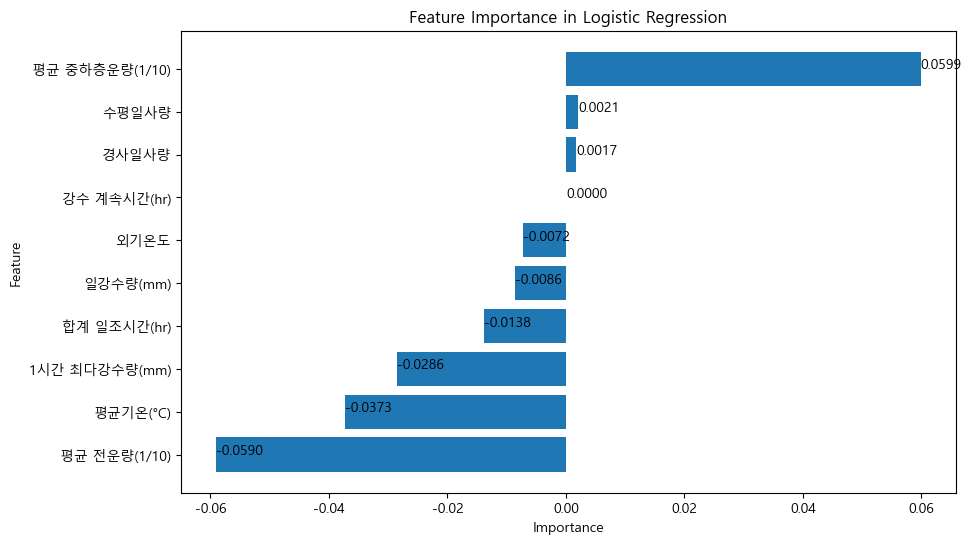

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# '위치'가 울산인 데이터만 선택
df_ulsan = df[df['위치'] == '동해']

# '위치'가 울산, 당진, 영광, 동해인 데이터만 선택 전체 514 울산 448 당진 321 동해 868
# df_ulsan = df[df['위치'].isin(['울산' , '당진' , '영광', '동해' ])] 

# '효율성' 열 추가 (현재발전출력 >= 124.97일 때 1, 그렇지 않으면 0)  417.15
df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 868).astype(int)

# 특성과 타겟 변수 설정
X = df_ulsan[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df_ulsan['효율성']

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 로지스틱 회귀 모델 정의 및 학습 (클래스 가중치 조정)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight={0: 1, 1: 0.5})
model.fit(X_resampled, y_resampled)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 계산
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')

# 중요도 값 텍스트 추가
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')

plt.gca().invert_yaxis()
plt.show()

Accuracy: 0.7922374429223744
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       351
           1       0.47      0.39      0.43        87

    accuracy                           0.79       438
   macro avg       0.66      0.64      0.65       438
weighted avg       0.78      0.79      0.78       438

          Feature  Importance
4     합계 일조시간(hr)    0.103433
6  평균 중하층운량(1/10)    0.086980
5    평균 전운량(1/10)    0.068923
1     강수 계속시간(hr)    0.014613
7           수평일사량    0.005674
8           경사일사량    0.003331
3        일강수량(mm)    0.000975
9            외기온도   -0.017747
2   1시간 최다강수량(mm)   -0.018761
0        평균기온(°C)   -0.029419


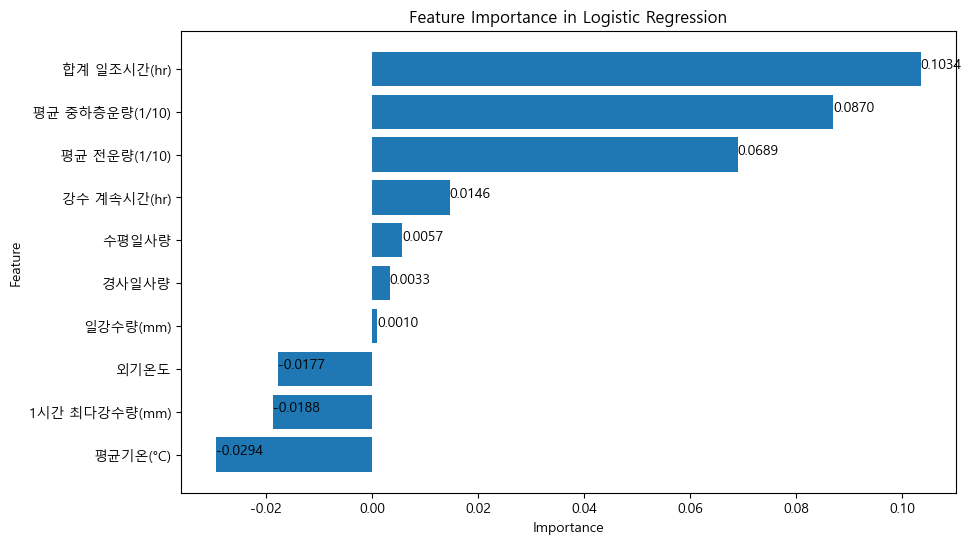

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# '위치'가 울산인 데이터만 선택
df_ulsan = df[df['위치'] == '울산']

# '위치'가 울산, 당진, 영광, 동해인 데이터만 선택 전체 514 울산 448 당진 321 동해 868
# df_ulsan = df[df['위치'].isin(['울산' , '당진' , '영광', '동해' ])] 

# '효율성' 열 추가 (현재발전출력 >= 124.97일 때 1, 그렇지 않으면 0)  417.15
df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 448).astype(int)

# 특성과 타겟 변수 설정
X = df_ulsan[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df_ulsan['효율성']

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 로지스틱 회귀 모델 정의 및 학습 (클래스 가중치 조정)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight={0: 1, 1: 0.5})
model.fit(X_resampled, y_resampled)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 계산
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')

# 중요도 값 텍스트 추가
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')

plt.gca().invert_yaxis()
plt.show()

In [45]:

!pip install imbalanced-learn


In [5]:
from imblearn.over_sampling import SMOTE

Accuracy: 0.773972602739726
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       354
           1       0.40      0.36      0.38        84

    accuracy                           0.77       438
   macro avg       0.63      0.62      0.62       438
weighted avg       0.76      0.77      0.77       438

          Feature  Importance
4     합계 일조시간(hr)    0.106480
2   1시간 최다강수량(mm)    0.096830
5    평균 전운량(1/10)    0.040766
9            외기온도    0.018896
1     강수 계속시간(hr)    0.016519
0        평균기온(°C)    0.012414
7           수평일사량    0.005253
8           경사일사량    0.003574
6  평균 중하층운량(1/10)   -0.000540
3        일강수량(mm)   -0.039015


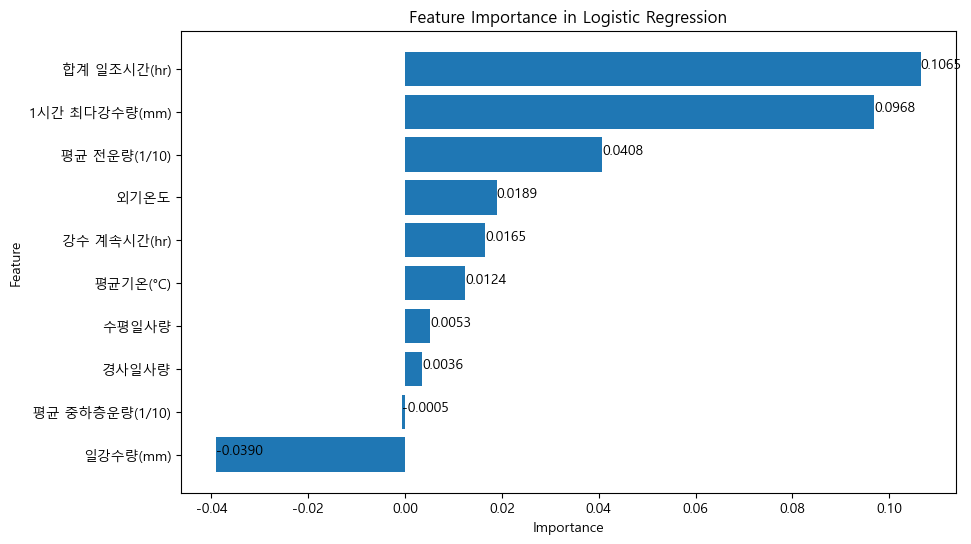

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# '위치'가 울산인 데이터만 선택
df_ulsan = df[df['위치'] == '당진']

# '위치'가 울산, 당진, 영광, 동해인 데이터만 선택 전체 514 울산 448 당진 321 동해 868
# df_ulsan = df[df['위치'].isin(['울산' , '당진' , '영광', '동해' ])] 

# '효율성' 열 추가 (현재발전출력 >= 124.97일 때 1, 그렇지 않으면 0)  417.15
df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 321).astype(int)

# 특성과 타겟 변수 설정
X = df_ulsan[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', 
        '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
        '수평일사량', '경사일사량', '외기온도']]
y = df_ulsan['효율성']

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 로지스틱 회귀 모델 정의 및 학습 (클래스 가중치 조정)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight={0: 1, 1: 0.5})
model.fit(X_resampled, y_resampled)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 계산
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')

# 중요도 값 텍스트 추가
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')

plt.gca().invert_yaxis()
plt.show()

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# 데이터 불러오기
df = pd.read_csv('C:/Users/campus4D045/Desktop/기계학습/weather1.csv')

# '일자' 열을 datetime 형식으로 변환하고 인덱스로 설정
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', inplace=True)

# '위치'가 영광인 데이터만 선택
df_ulsan = df[df['위치'] == '영광']

# '효율성' 열 추가 (현재발전출력 >= 124.97일 때 1, 그렇지 않으면 0)
df_ulsan['효율성'] = (df_ulsan['현재발전출력'] >= 124.97).astype(int)

# 특성과 타겟 변수 설정
X = df_ulsan[['평균기온(°C)', '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', 
              '합계 일조시간(hr)', '평균 전운량(1/10)', '평균 중하층운량(1/10)', 
              '수평일사량', '경사일사량', '외기온도']]
y = df_ulsan['효율성']

# 데이터 분리: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 정의 및 학습 (클래스 가중치 조정)
model = LogisticRegression(max_iter=1000, random_state=42, class_weight={0: 1, 1: 0.5})
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 계산
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')

# 중요도 값 텍스트 추가
for index, value in enumerate(feature_importance['Importance']):
    plt.text(value, index, f'{value:.4f}')

plt.gca().invert_yaxis()
plt.show()

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0